# Generación por Autoencoders

Este ejemplo buenísimo muestra como se puede usar la información del espacio latente de los autoencoders para interpolar nuevos ejemplos de los dígitos de códigos postales de MNIST.

Está sacado del libro de Langr, "GANs in action"

In [132]:

from __future__ import print_function

#!pip install numpy==1.19.5
#!pip install tensorflow==2.2.0
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#from tensorflow import keras
### hack tf-keras to appear as top level keras
#import sys
#sys.modules['keras'] = keras
### end of hack

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()



print(np.__version__)



1.22.3


In [133]:

# defining the key parameters
batch_size = 10

# Parameters of the input images (handwritten digits)
original_dim = 28*28

# Latent space is of dimension 2.  This means that we are reducing the dimension from 784 to 2
latent_dim = 2
intermediate_dim = 16*16
epochs = 100
epsilon_std = 1

La función de Sampling es la que toma la salida de la media y la varianza que estima el Encoder y la usa para generar una muestra que va a servir a estimar la pdf de los datos.

In [134]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    print(z_mean)
    print(z_log_var)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon  # h(z)

# Codificador

Esta primera parte define el codificador, es decir la primera red que baja la dimensionalidad de los datos.

In [135]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Tensor("mean_9/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("log-variance_9/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         

# Decodificador

Esta segunda parte es la definición del decodificador, que es la segunda parte que decodifica la información del espacio latente hacia la salida final de las dos redes en serie.

In [136]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


# Autoencoder completo

Se combinan las dos partes.  Primero el Codificador y luego del decodifcador.  Acá se muestra la información de cómo queda el modelo.

In [137]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Tensor("encoder_9/mean/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("encoder_9/log-variance/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Función de perdida

Se define la función de perdida, y se establece cuál va a ser la función de optimización.

In [138]:
import tensorflow as tf
from keras.datasets import mnist
from keras import metrics

In [139]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  # Aca se computa la cross entropy entre los "labels" x que son los valores 0/1 de los pixeles, y lo que salió al final del Decoder.
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # x-^X
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile( loss=vae_loss)
vae.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


Se cargan los datos de la base de datos de MNIST

12


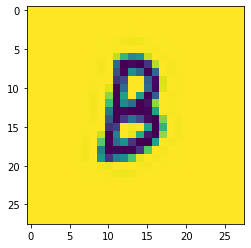

In [140]:
from matplotlib import image
import os
from parse import *
from matplotlib import pyplot as plt
images_names = os.listdir("./handwritting4")
#np.random.RandomState(17).shuffle(images_names)
labels = np.array([int(parse("img{}-{}.png", name)[0]) for name in images_names])
images = np.array([image.imread("./handwritting4/" + name) for name in images_names])
size = len(images)
plt.imshow(images[2])
print(labels[2])
plt.show()
# x_train = images[0:size*85//100]
# x_test = images[size*85//100:size]
# y_train = labels[0:size*85//100]
# y_test = labels[size*85//100:size]
indexes = np.random.RandomState(17).choice(size, size=size//10, replace=False)
x_train = images
x_test = images
#x_test = images[indexes]
y_test = labels
y_train = labels
#y_test = labels[indexes]


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Se entrena finalmente la red de forma completa.

In [141]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)


Train on 440 samples
Epoch 1/100
440/440 [==============================] - 1s 2ms/sample - loss: 238.3460
Epoch 2/100
440/440 [==============================] - 0s 536us/sample - loss: 149.6115
Epoch 3/100
440/440 [==============================] - 0s 560us/sample - loss: 138.2617
Epoch 4/100
440/440 [==============================] - 0s 548us/sample - loss: 131.6349
Epoch 5/100
440/440 [==============================] - 0s 480us/sample - loss: 127.6021
Epoch 6/100
440/440 [==============================] - 0s 523us/sample - loss: 124.2076
Epoch 7/100
440/440 [==============================] - 0s 532us/sample - loss: 122.8845
Epoch 8/100
440/440 [==============================] - 0s 548us/sample - loss: 119.6921
Epoch 9/100
440/440 [==============================] - 0s 476us/sample - loss: 118.1937
Epoch 10/100
440/440 [==============================] - 0s 506us/sample - loss: 117.0266
Epoch 11/100
440/440 [==============================] - 0s 530us/sample - loss: 116.5004
Epoch 12/10

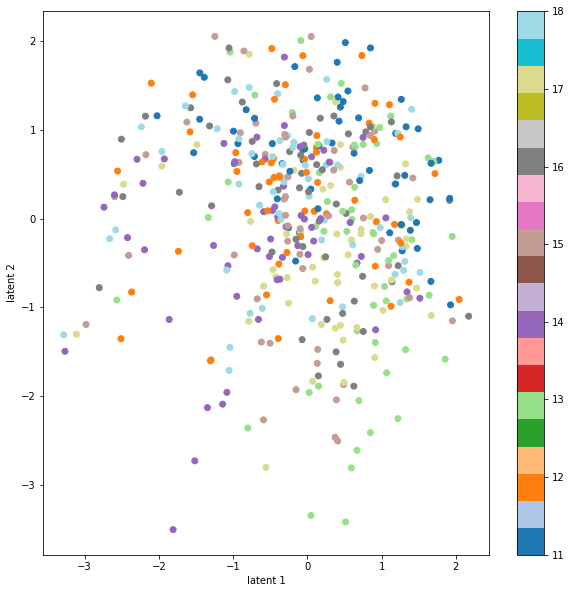

In [142]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='tab20')
plt.colorbar()
plt.xlabel("latent 1")
plt.ylabel("latent 2")
plt.show()

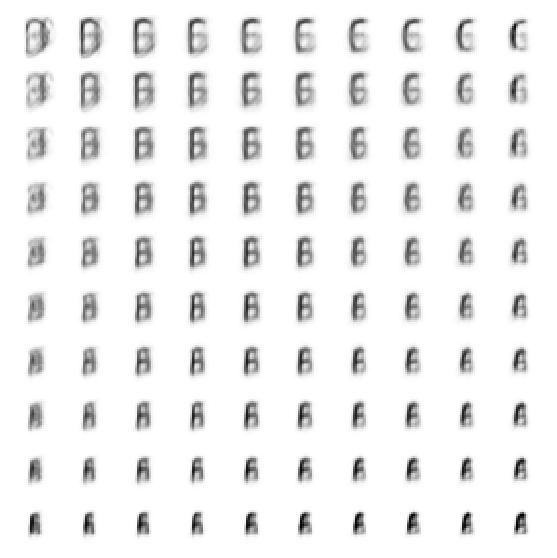

In [143]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.gca().set_axis_off()
plt.show()

In [144]:
print(grid_x)


[-1.64485363 -1.03643339 -0.67448975 -0.38532047 -0.12566135  0.12566135
  0.38532047  0.67448975  1.03643339  1.64485363]


In [145]:
print(z_sample)

[[1.64485363 1.64485363]]
